In [0]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special
%matplotlib inline

# Домашнее задание 2

## Методы интегрирования (30 баллов)

Пусть $f: R \to R$ -- некоторая (достаточно) гладкая функция, с известными значениями $f(x_i)$ в точках $x_i$. Требуется вычислить интеграл
\[
\int_a^b f(x) dx.
\]
Для этого будем использовать составные формулы Ньютона-Котеса.

### Составные формулы для произвольной сетки

Будем полагать сетку произвольной, если сетка равномерная (что на практике бывает не всегда), то формулы хорошо известны.

#### Запись формул (5 баллов)

Формулы Ньютона-Котеса -- формулы, которые получаются при интегрировании интерполяционного многочлена. Пусть мы используем $K$ элементарных отрезков, на каждом из которых есть $n$ узлов (включая два крайних). Выпишите простую и составную формулу интегрирования. 

#### ВАШЕ РЕШЕНИЕ ЗДЕСЬ

Выпишите аналогичные формулы, которые получаются при интерполировании функции $f$ кубическим сплайном дефекта 1.

#### ВАШЕ РЕШЕНИЕ ЗДЕСЬ

#### Программная реализация (10 баллов)

Реализуйте два метода интегрирования: на формулах Ньютона-Котеса и на кубических сплайнах дефекта 1. Для вычисления коэффициентов интерполяции можете использовать готовые решения из предыдущих домашних и семинарских работ.

In [0]:
class NewtonInterpolator:
    def __init__(self,xs,fs):
        self.fs = fs
        self.xs = xs
        self.diffs = [self.fs]
        for i in np.arange(1,len(self.fs)):
            diff = np.array([ (self.diffs[-1][k+1]-self.diffs[-1][k])/(self.xs[i+k]-self.xs[k])\
                          for k in np.arange(len(self.diffs[-1])-1)])
            self.diffs = self.diffs +[diff]
        self.coefs = np.array([ self.diffs[k][0] for k in np.arange(len(self.diffs))])
        self.cs = list()
        for j in range(0, len(xs)):
            xj = np.ones(len(xs) - 1) * xs[j]
            xk = np.concatenate((xs[:j], xs[(j+1):]))
            pint = np.polynomial.polynomial.polyint(np.polynomial.polynomial.polyfromroots(xk))
            I = np.polynomial.polynomial.polyval(xs[-1], pint) - np.polynomial.polynomial.polyval(xs[0], pint)
            self.cs.append(I * fs[j] / (xj - xk).prod())
        self.I = np.sum(self.cs)
        
    def Compute(self,x):
        #print(x)
        if(x.shape[0]>1):
            vals = np.cumprod( x[:,None] - self.xs[None,:], axis=-1)[:,:-1]
        else:
            vals = np.cumprod( x - self.xs[None,:], axis=-1)[:,:-1]
        vals = np.concatenate([np.ones([x.shape[0],1]), vals],axis=-1)
        return vals@self.coefs
    

class PiecewiseNewtonInterpolator:
    def name(self):
        return "PiecewiseNewton, N=" + str(self.N)
    def __init__(self,xs,fs, N):
        self.N = N
        self.M = (len(xs) - 1) / (N - 1)
        assert(int(self.M) == self.M)
        self.M = int(self.M)
        assert((xs == sorted(xs)).all())
        self.xs = xs
        self.polys = list()
        self.bxs = list()
        self.I = 0
        for i in range(0, self.M):
          a = i*(N-1)
          b = a + N
          self.bxs.append(xs[a])
          self.polys.append(NewtonInterpolator(xs[a:b], fs[a:b]))
          self.I += self.polys[-1].I
        self._compute = np.vectorize(lambda x: self._c(x))

    def _c(self, x):
        i = 0
        while i < len(self.bxs) - 1 and self.bxs[i+1] < x:
          i+=1
        return self.polys[i].Compute(np.ones(1)*x)

    def Compute(self,xs):
        return self._compute(xs)
    
class CubicSplineInterpolator:
    def name(self):
        return "Spline"

    def __init__(self,xGrid,fGrid, ddSa = 0., ddSb = 0.):
        self.xs = xGrid
        self.ys = fGrid
        self.n = len(self.xs) - 1
        self.ddSa = ddSa
        self.ddSb = ddSb
        self.coeffs = self.ComputeCoefficients(xGrid,fGrid)
        
    def ComputeCoefficients(self,xs,ys):
        #    coeffs
        n = len(xs) - 1
        h = xs[1:] - xs[:-1]
        assert(np.all(h >= 0))
        #print(h)
        a = h[:-1] / (h[:-1] + h[1:])
        b = np.ones(n - 1) - a
        a = np.append(a, [0,])
        b = np.append([0,], b)
        #print(a)
        #print(b)
        g = ys[1:] - ys[:-1]
        gh = g / h
        d = (g[1:] - g[:-1]) / (h[:-1] + h[1:])
        d = np.concatenate(([2*self.ddSa,], 6*d, [2*self.ddSb,]))
        #print('d', d)
        #mat = scipy.sparse.diags((a, 2*np.ones(n+1), b), offsets=(-1, 0, 1)).toarray()
        #print(mat)
        #print('exp', np.linalg.solve(mat, d))
        m = self._solve(a, 2*np.ones(n+1), b, d)
        #print('got', np.matmul(mat, m))
        self._postproc(m, h, ys)
        self._compute = np.vectorize(lambda x: self._s(x))
        return self.c

    def _solve(self, a, b, c, d):
        n = len(d)
        p = [-c[0] / b[0],]
        q = [d[0] / b[0],]
        for i in range(1, n - 1):
          p.append(c[i] / (-a[i-1]*p[i-1] -b[i]))
          q.append((-d[i] + a[i-1] * q[i-1]) / (-a[i-1]*p[i-1] - b[i]))
        #print('p', p)
        #print('q', q)
        x = [(d[n-1] - q[n-2]*a[n-2]) / (b[n-1] + p[n-2]*a[n-2]),]
        #print(n-1, x[0])
        for i in range(n - 2, -1, -1):
          x.append(p[i]*x[-1] + q[i])
          #print(i, x[-1])
        #print(x)
        return np.flip(x)

    def _postproc(self, m, h, y):
        c0 = m[:-1] / (6*h) # (x_i - x)^3
        c1 = m[1:] / (6*h)  # (x - x_{i-1})^3
        c2 = (y[:-1] - (m[:-1]*h*h)/6)/h  # (x_i - x)
        c3 = (y[1:] - (m[1:]*h*h)/6)/h    # (x - x_{i-i})
        self.c = np.array([c0, c1, c2, c3])
        self.I = 0
        for i in range(1, len(self.xs)):
            a = self.xs[i]
            b = self.xs[i-1]
            #print(a, b, self._cI(a, i-1), self._cI(b, i-1), (self._cI(a, i-1) - self._cI(b, i-1)), sep='\t')
            self.I += (self._cI(a, i-1) - self._cI(b, i-1))
        #print(self.c)

    def _ci(self, x, i):
        return self.c[0][i]*(self.xs[i+1] - x)**3 + \
               self.c[1][i]*(x - self.xs[i])**3 + \
               self.c[2][i]*(self.xs[i+1] - x) + \
               self.c[3][i]*(x - self.xs[i])

    def _cI(self, x, i):
        return -0.25*self.c[0][i]*(self.xs[i+1] - x)**4 + \
               0.25*self.c[1][i]*(x - self.xs[i])**4 + \
               -0.5*self.c[2][i]*(self.xs[i+1] - x)**2 + \
               0.5*self.c[3][i]*(x - self.xs[i])**2

    def _s(self, x):
        if x < self.xs[0] or self.xs[-1] < x:
          raise Exception('undefined')
        i = 0
        while self.xs[i+1] < x:
          i+=1 
        return self._ci(x, i)

    def Compute(self,x):
        return self._compute(x)
    
def NewtonCotesIntegral(xs,fs):
    def __init__(self,xs,fs, N):
        self.pni = PiecewiseNewtonInterpolator(xs, fs)

    def Compute(self):
        return self.pni.I

def CubicSplineIntegral(xs,fs):
    def __init__(self,xs,fs, N):
        self.csi = CubicSplineInterpolator(xs, fs)

    def Compute(self):
        return self.pni.I
    

In [43]:
xs = np.array([1, 2, 3, 4, 5])
np.concatenate((xs[1:2], xs[(2+1):]))
xs[1:2]
np.array(42)

array(42)

Протестируем.

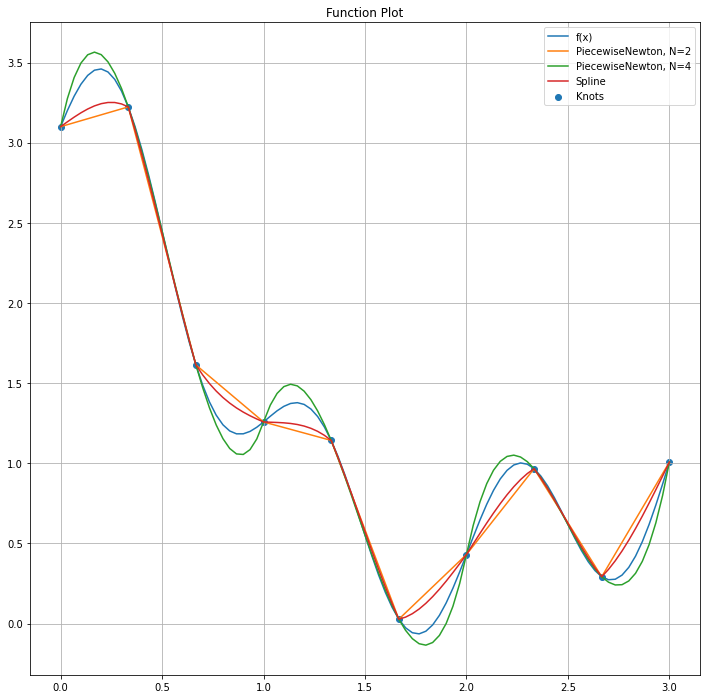

In [157]:
def testF(x):
    return 3*np.exp(-x**2) + 0.1* np.cosh(x) + 0.5*np.sin(2*np.pi*x)

N=10#number of points in the grid
x0=0
x1=3
h=(x1-x0)/(N-1)

xs = np.arange(x0,x1+h/2,h)
fs = testF(xs)

#Compute interpoants
interpolators = [PiecewiseNewtonInterpolator(xs,fs, 2), PiecewiseNewtonInterpolator(xs,fs, 4),CubicSplineInterpolator(xs,fs)]
#Compute their values on the Dense grid
#interpFs =

xsDense = np.arange(x0,x1+h/20,h/10)#for visualization solely
fsDense = testF(xsDense)
fs0 = interpolators[0].Compute(xsDense)
fs1 = interpolators[1].Compute(xsDense)
fs2 = interpolators[2].Compute(xsDense)
f,ax = plt.subplots(figsize=(12,12))

ax.grid()
ax.set_title('Function Plot')
ax.scatter(xs,fs, label='Knots')
ax.plot(xsDense,fsDense, label='f(x)')
ax.plot(xsDense,fs0, label=interpolators[0].name())
ax.plot(xsDense,fs1, label=interpolators[1].name())
ax.plot(xsDense,fs2, label=interpolators[2].name())
ax.legend()

In [158]:

# Похоже, интегрирование работает

def testFI(x):
    # Wolfram: integrate 3*exp(-x**2) + 0.1* cosh(x) + 0.5*sin(2*pi*x)
    return 0.1 *(-0.795775*np.cos(6.28319*x) + 26.5868*scipy.special.erf(x) + np.sinh(x))

I = testFI(3) - testFI(0)
print(I)
for i in interpolators:
  print(i.I)

3.660408761186316
3.6696487276937617
3.6605196827473296
3.6650083888029896


#### Исследование сходимости (15 баллов)

Нарисуйте ошибку интегрирования $\left\vert \int_a^b f(x)dx - Integrator(xs,fs) \right\vert$ для реализованных интеграторов при разных сетках на элементарных отрезках (равномерная, чебышёвская) и разном числе узлов $N$. Какой метод является точнее? Попробуйте оценить порядок точности схемы экспериментально с помощью рассмотрения графика в $log-log$ осях. Как с его помощью можно оценить порядок точности?

Примечание: для вычисления точного значения интеграла можете использовать какой-нибудь очень точный метод; например, что-то из scipy.integrate или wolfram.

In [0]:
def err(N):
  x0=0
  x1=3
  h=(x1-x0)/(N-1)

  xs = np.arange(x0,x1+h/2,h)
  fs = testF(xs)

  interpolators = [PiecewiseNewtonInterpolator(xs,fs, 2), PiecewiseNewtonInterpolator(xs,fs, 3), PiecewiseNewtonInterpolator(xs,fs, 4), PiecewiseNewtonInterpolator(xs,fs, 5), CubicSplineInterpolator(xs,fs)]
  errs = [abs(I - x.I) for x in interpolators]
  names = [x.name() for x in interpolators]
  return errs, names



In [150]:
_, names = err(13)

# (N-1) должно делиться на 4, 3 и 2 т.е. на 12
Ns = range(13, 122, 12)
errs = [list() for x in range(0, len(names))]

for i in range(0, len(Ns)):
  e, _ = err(Ns[i])
  for j in range(0, len(names)):
    errs[j].append(e[j])

errs

[[0.005201773216899408,
  0.0013019775693119406,
  0.0005791663065828345,
  0.0003261361092374848,
  0.00020901115631577483,
  0.00014538557178234157,
  0.00010702061854050982,
  8.211999336493747e-05,
  6.504807253016054e-05,
  5.28365610330539e-05],
 [2.112158710732004e-05,
  2.045686800844493e-06,
  1.0269651151695314e-06,
  8.556226940292788e-07,
  8.08807754992813e-07,
  7.91993471693786e-07,
  7.847846408282066e-07,
  7.812884272873077e-07,
  7.794221037471516e-07,
  7.783553228613016e-07],
 [4.6569546000796436e-05,
  3.634276985575724e-06,
  1.340444404807073e-06,
  9.54768386129956e-07,
  8.494687460114392e-07,
  8.114862994901273e-07,
  7.954705796286987e-07,
  7.874458756162994e-07,
  7.833599702244953e-07,
  7.811928535161883e-07],
 [6.916665005629596e-06,
  7.739873764123217e-07,
  7.761120905946939e-07,
  7.76315971950936e-07,
  7.757254265605695e-07,
  7.719742018963416e-07,
  7.722053663172801e-07,
  7.800498820209611e-07,
  7.936869090841014e-07,
  7.759928091211066e-07

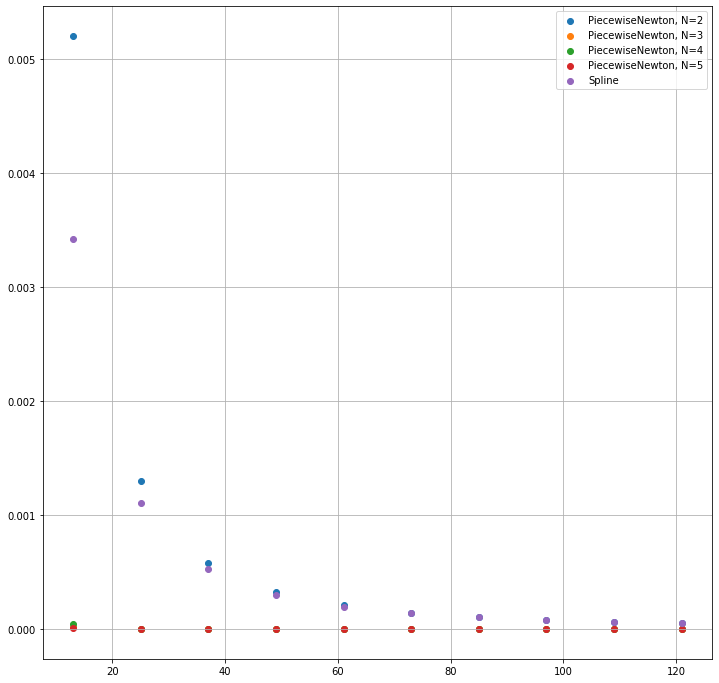

In [156]:
f,ax = plt.subplots(figsize=(12,12))

ax.grid()
for i in range(0, len(names)):
  ax.scatter(Ns,errs[i], label=names[i])
ax.legend()

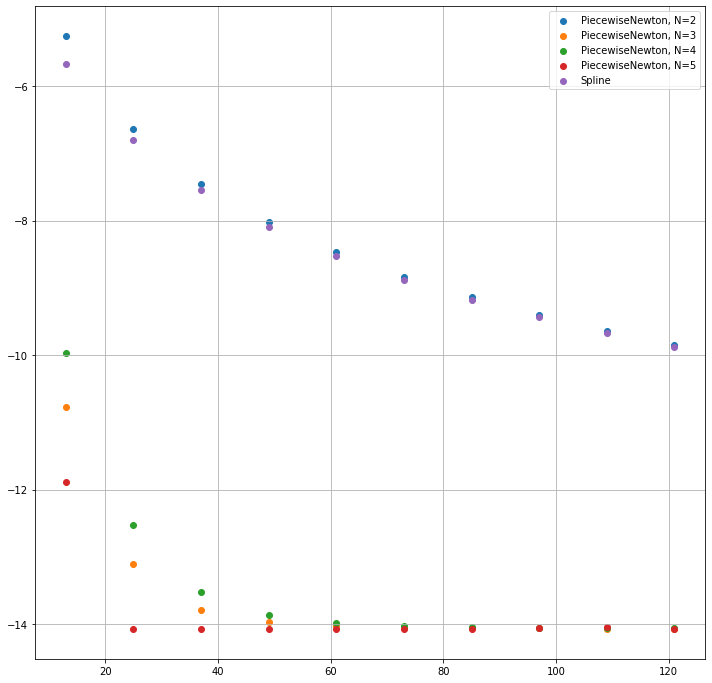

In [159]:
f,ax = plt.subplots(figsize=(12,12))

ax.grid()
for i in range(0, len(names)):
  ax.scatter(Ns,np.log(errs[i]), label=names[i])
ax.legend()

## Простейшие матричные разложения (70 баллов)

На лекции разбирался метод $LU$-разложения, который является матричной записью метода Гаусса. В этом задании мы исследуем его работу и устойчивость, а также разберём ещё одно важное матричное разложение -- разложение Холецкого. Для простоты будем работать с вещественными квадратными матрицами.

### LU (15 баллов)

Это разложение определено для любой невырожденной $n \times n$ матрицы $A$ и записывается как $A=LU$, где $L$ -- нижнетреугольная $n \times n$ матрица, $U$ -- верхнетреугольная. Почему такое разложение неединственно и как добиться единственности?

Прямое вычисление $LU$ разложения неустойчиво, поэтому обычно дополнительно используют выбор главного элемента по строке и столбцу.

Выведите формулы для вычисления $LU$-разложения и опишите как использовать выбор главного элемента.

#### ВАШЕ РЕШЕНИЕ ЗДЕСЬ

Теперь имплементируйте.

In [0]:
def LUDecomposition(A):
    #IN:
    # A [n,n] -- matrix to decompose
    #OUT:
    # LU [n,n] -- matrix decomposition represented as one matrix (think on how to do it!)
    pass

### Разложение Холецкого (15 баллов)

Разложение Холецкого определено для любой положительно определённой симметричной матрицы $A$ и определяется как $A=LL^*$, где $L$ -- нижнетреугольная $n \times n$ матрица.

Выведите формулы для вычисления разложения Холецкого.

#### ВАШЕ РЕШЕНИЕ ЗДЕСЬ

Имплементируйте метод.

In [0]:
def CholetskyDecomposition(A):
    #IN:
    # A [n,n] -- matrix to decompose
    #OUT:
    # L [n(n+1)/2] -- matrix decomposition represented as 1-dimensional array (think on how to do it!)
    pass

In [0]:
#Let us check if all works
#print np.linalg.norm(A - L@U) for LU
#print np.linalg.norm(A - LL*) for Choletsky

Разложения используют для решения очень многих задач линейной алгебры: для вычисления определителя, решения СЛАУ, нахождения обратной матрицы...

Здесь мы будем заниматься решением СЛАУ. Опишите формулы, по которым можно вычислить решение СЛАУ, имея разложение Холецкого или $LU$.

### Случайные матрицы из гауссовского распределения (10 баллов)

Случайные матрицы 
$$
A=(a_{ij}), \quad a_{ij} \sim^{iid} \mathcal{N}(0,10)
$$
известны своими хорошими свойствами обусловленности, поэтому прямые методы, такие, как $LU$, должны работать очень точно.

Нарисуйте два графика:
1. График среднего (усредните по $K=1000$ симуляциям) числа обусловленности матрицы $AA^*$ в зависимости от размера $n$;
2. График средней (усредните по $K=1000$ симуляциям) относительной ошибки решения c помощью $LU$ и разложения Холецкого системы уравнений с матрицей $AA^*$ правой частью $f=1$;

In [0]:
#YOUR CODE HERE

### Матрица Гильберта (15 баллов)

Матрица Гильберта -- это матрица $H=(h_{ij})$ с элементами  $h_{ij}=1/(i+j-1)$.

Докажите, что эта матрица положительно определена (5 баллов).
#### ВАШЕ РЕШЕНИЕ ЗДЕСЬ

Нарисуйте два графика(10 баллов):
1. График числа обусловленности матрицы $H$ в зависимости от размера $n$;
2. График относительной ошибки решения c помощью $LU$ и разложения Холецкого системы уравнений с матрицей $H$ правой частью $f=1$.

In [0]:
#YOUR CODE HERE

Сделайте выводы по проделанным экспериментам.

### Семплирование из гауссовского распределения с заданной ковариационной матрицей (15 баллов)

Очень частая задача в статистике -- семплирование из многомерного гауссовского распределения с заданной ковариацией. В частности, в регрессии гауссовскими процессами.

Вещественнозначным случайным процессом (проиндексированным некоторым абстрактным множеством $T$) назовём семейство случайных величин $(X_t)_{t \in T}$. Такой процесс называется гауссовским, если для любого $N$ и любых $N$ точек $t_i \in T, i=1,..,N$ совместное распределение величин $X_{t_i}$ является гауссовским. Любой гауссовский процесс определяется своими средним $\mu(t)= E\left[ X_t \right]$ и ковариационной функцией $K(t,s):=Cov(X_t,X_s)$, определённых для $t,s \in T$. Положим для простоты $T= R$, так процесс проиндексирован вещественной прямой.

Гауссовские процессы -- очень мощный интрумент регрессии, но про него расскажут в других курсах.

Давайте попробуем семплировать несколько траекторий такого процесса. Поскольку процесс -- гауссовский, семплирование сводится к семплированию из гауссовского распределения с заданным средним $\mu$ и ковариацией $\Sigma$.

Опишите и обоснуйте метод семплирования, который использует разложение Холецкого матрицы $\Sigma \in R^{n \times n}$ и принимает на вход семплы из стандартного гауссовского распределения $\mathcal{N}(0,1)^n$ (np.random.randn).

Имплементируйте класс GaussianProcess ниже.

Нарисуйте два графика:
1. Семплы на сетке ts траекторий белого шума $X_t \sim \mathcal{N}(0,1)$, можете использовать тот же класс с нулевым средним и ковариацией $K(t,t)=1, K(t,s)=0$ для всех $t \neq s$;
2. Семплы на сетке ts траекторий гауссовского процесса.

Для (2) попробуйте два разных средних $\mu(t)$ и (например) такие ковариационные функции:
1. Exp-Sine-Squared (с параметрами $p,l$)
$$
K(t,s) = exp\left\lbrace -2\left(\frac{sin(\pi/p \cdot \vert t-s \vert)}{l}\right)^2 \right\rbrace;
$$
2. Rational quadratic (с параметрами $\alpha, l$ )
$$
K(t,s)=\left(1+\frac{( t - s )^2}{2 \alpha l^2}\right)^{-\alpha}.
$$
Большой выбор ковариационных функций представлен в sklearn (https://scikit-learn.org/stable/modules/gaussian_process.html).

In [0]:
class GaussianProcess:
    def __init__(self, meanFunction, covarianceFunction):
        #meanFunction functionHandler: R -> R
        #covarianceFunction functionHandler: R x R -> R
        pass
    def Sample(self, ts, N):
        #ts [batch] -- time grid of points where the value of the process is required
        #N -- number of sampled trajectories
        pass

In [0]:
#YOUR DRAWINGS!